# Dataset

https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification

# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import pickle  # saves time for longer computations at cost of space
import time
from sklearn.metrics import classification_report, accuracy_score

# Loading, Preprocessing, and Analysis

## Load the Dataset

In [2]:
# The dataset was giving issues with encoding, so this is an approach to find an encoding that works.

encodings = ["utf-8", "ISO-8859-1", "cp1252", "utf-16"]

file_path = "alldata1_for_kaggle.csv"

def read_csv_with_different_encodings(file_path, encodings):
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Successfully read file with encoding: {encoding}")
            return df
        except UnicodeDecodeError as e:
            print(f"Error with {encoding}: {e}")

    raise ValueError("None of the encodings worked. Please check the file's encoding.")

df = read_csv_with_different_encodings(file_path, encodings)

Successfully read file with encoding: utf-8


In [3]:
df.head()

,id,class,text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


## Preprocessing

In [4]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Replacing large space gaps with a single space
    text = re.sub(r"\s+", " ", text)

    # Removing special characters and digits
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return " ".join(filtered_tokens)

In [5]:
vectorizer = CountVectorizer(preprocessor=preprocess_text)
le = LabelEncoder()

In [6]:
X, y = df["text"], df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [7]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

## Feature Reduction

At present, the feature space is excessively large. We intend to implement a feature reduction technique with the goal of eliminating words that do not distinctly define classes and offer limited or redundant information with respect to the class variable.

In [8]:
K = 1000  # analysis purposes; this should suffice
chi2_selector = SelectKBest(chi2, k=K)
X_train_vectorized_reduced = chi2_selector.fit_transform(X_train_vectorized, y_train_encoded)
X_test_vectorized_reduced = chi2_selector.transform(X_test_vectorized)

In [9]:
X_train_vectorized_reduced.shape

(800, 1000)

In [10]:
X_test_vectorized_reduced.shape

(200, 1000)

## Term Frequency Plots

A curiosity is what the impact of the most frequent words have with each class.

In [11]:
def get_top_info(X, top=40):
    """
    Returns the top "top"-most frequent features (words) in a sparse matrix "X" along with their counts and indices.

    Parameters:
        X : Input feature matrix.
        top : Number of top features to return.

    Returns:
        top_words : Names of top "top" features sorted by total counts.
        top_counts : Counts of top "top" features.
        top_indices : Indices of top "top" features in "X".
    """
    
    feature_names = vectorizer.get_feature_names_out()
    feature_counts = X.sum(axis=0).A1
    top_indices = feature_counts.argsort()[-top:]
    top_words = feature_names[top_indices]
    top_counts = feature_counts[top_indices]
    top_words, top_counts = top_words[::-1], top_counts[::-1]
    return top_words, top_counts, top_indices

In [12]:
def plot_term_frequency_distribution(X, y=None, class_=None, top=40):
    """
    Plots the frequency distribution of the top "top" words in a given feature matrix "X".

    Parameters:
        X : Input feature matrix.
        y : Target class labels.
        class_ : Specific class label to filter data for.
        top : Number of top words to plot.

    Creates a bar plot whereby each bar is a word from the top "top" words in its class, with a height representative of
    its frequency within its filtered class. If class is None, uses all classes.
    """
    
    if class_ is not None:
        X = X[y == class_]

    top_words, top_counts, _ = get_top_info(X, top=top)

    plt.figure(figsize=(15, 10))
    cmap = plt.get_cmap("viridis")
    norm = mcolors.Normalize(vmin=min(top_counts), vmax=max(top_counts))
    plt.bar(top_words,
            top_counts,
            color=cmap(norm(top_counts)))
    plt.xticks(rotation=45)
    plt.xlabel("Words", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    title = f"Top-{top} Term Frequency Distribution"
    if class_ is not None:
        title += f" for {class_!r}"
    plt.title(title, fontsize=18)
    plt.show()

### Top Term Frequency Distribution

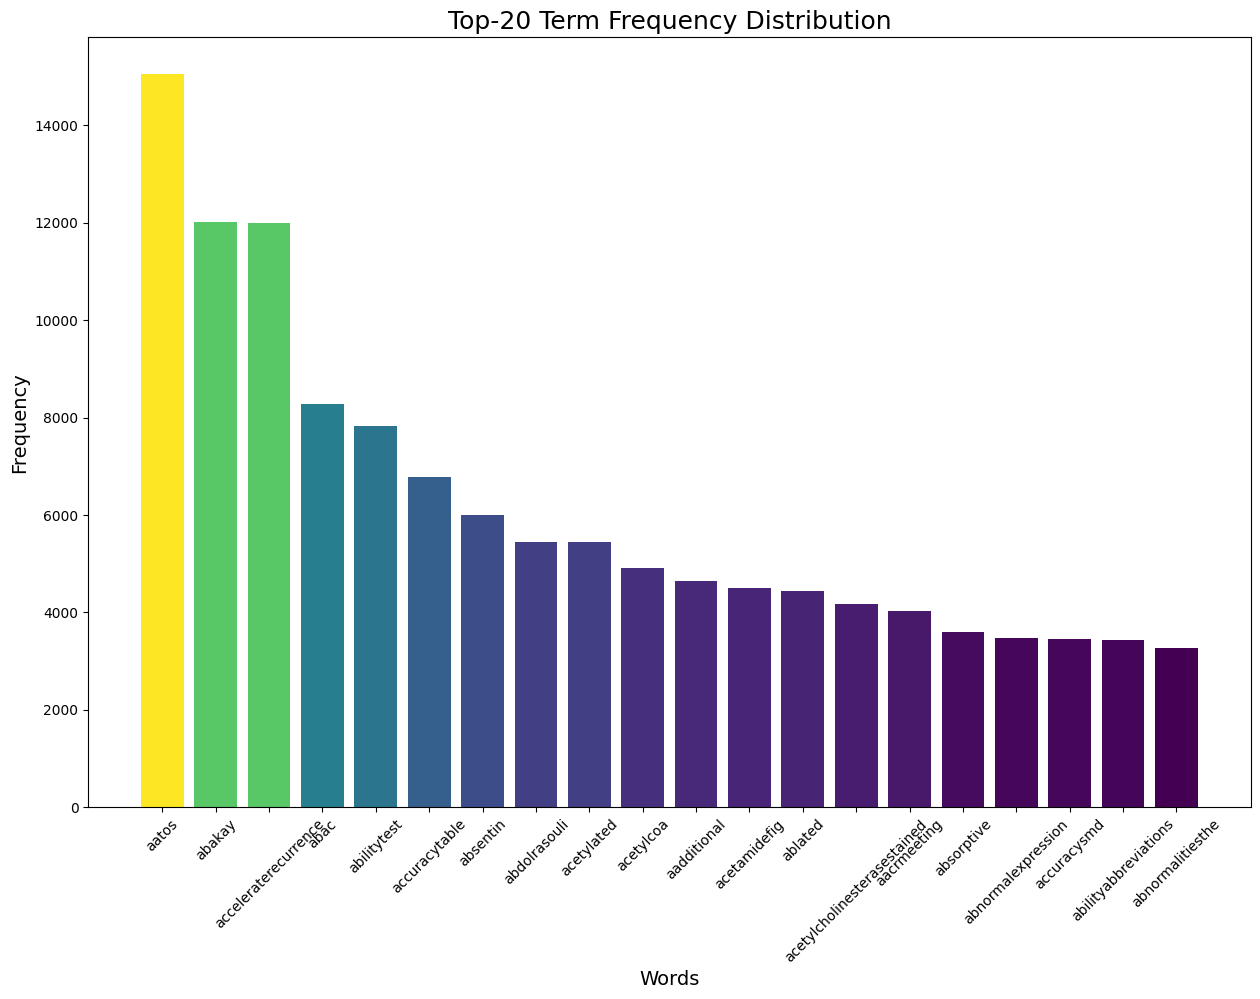

In [13]:
plot_term_frequency_distribution(X_train_vectorized_reduced, top=20)

### Term Frequency Distribution for Each Class

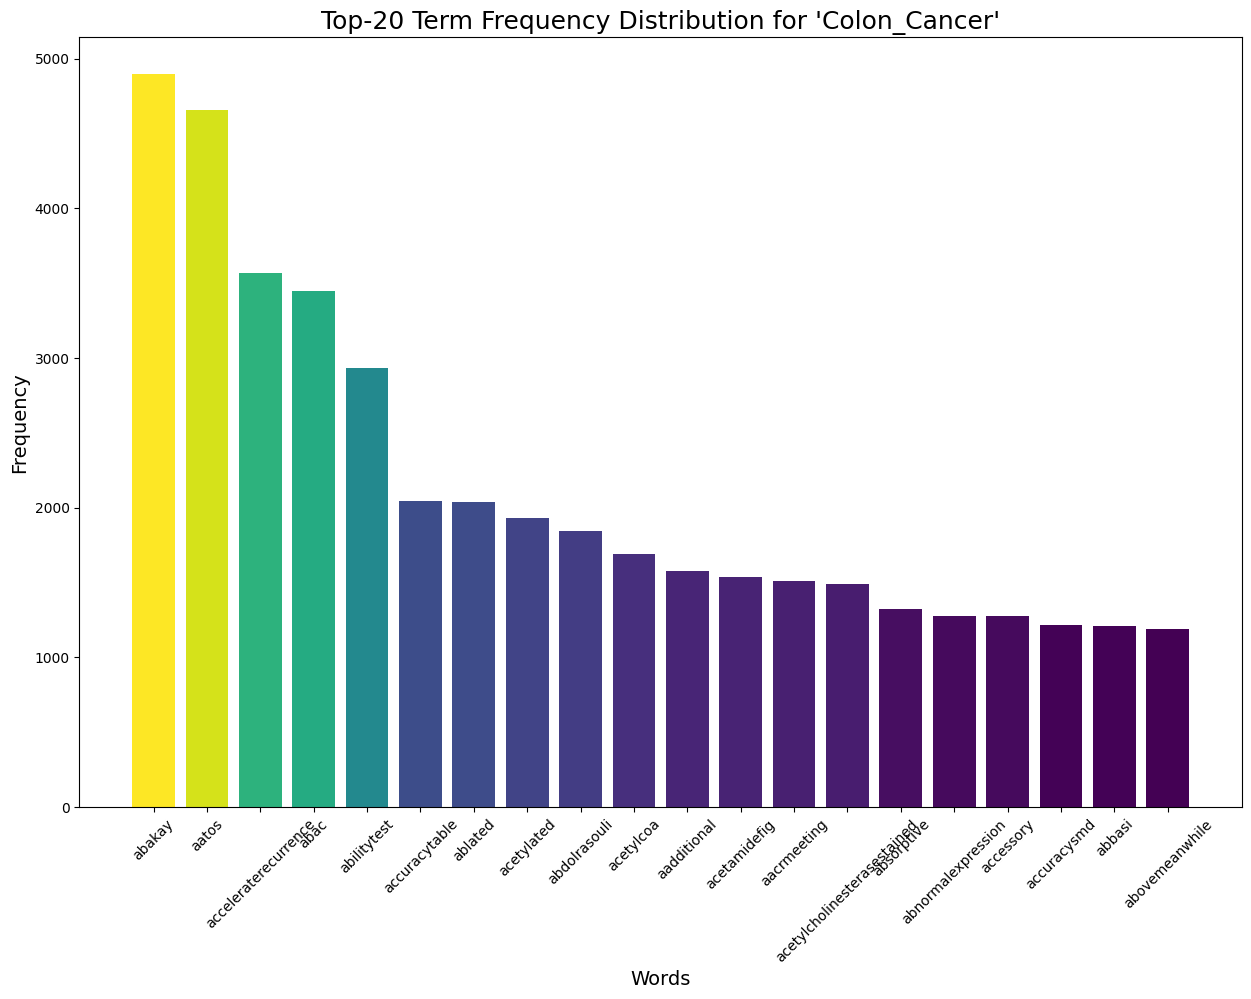

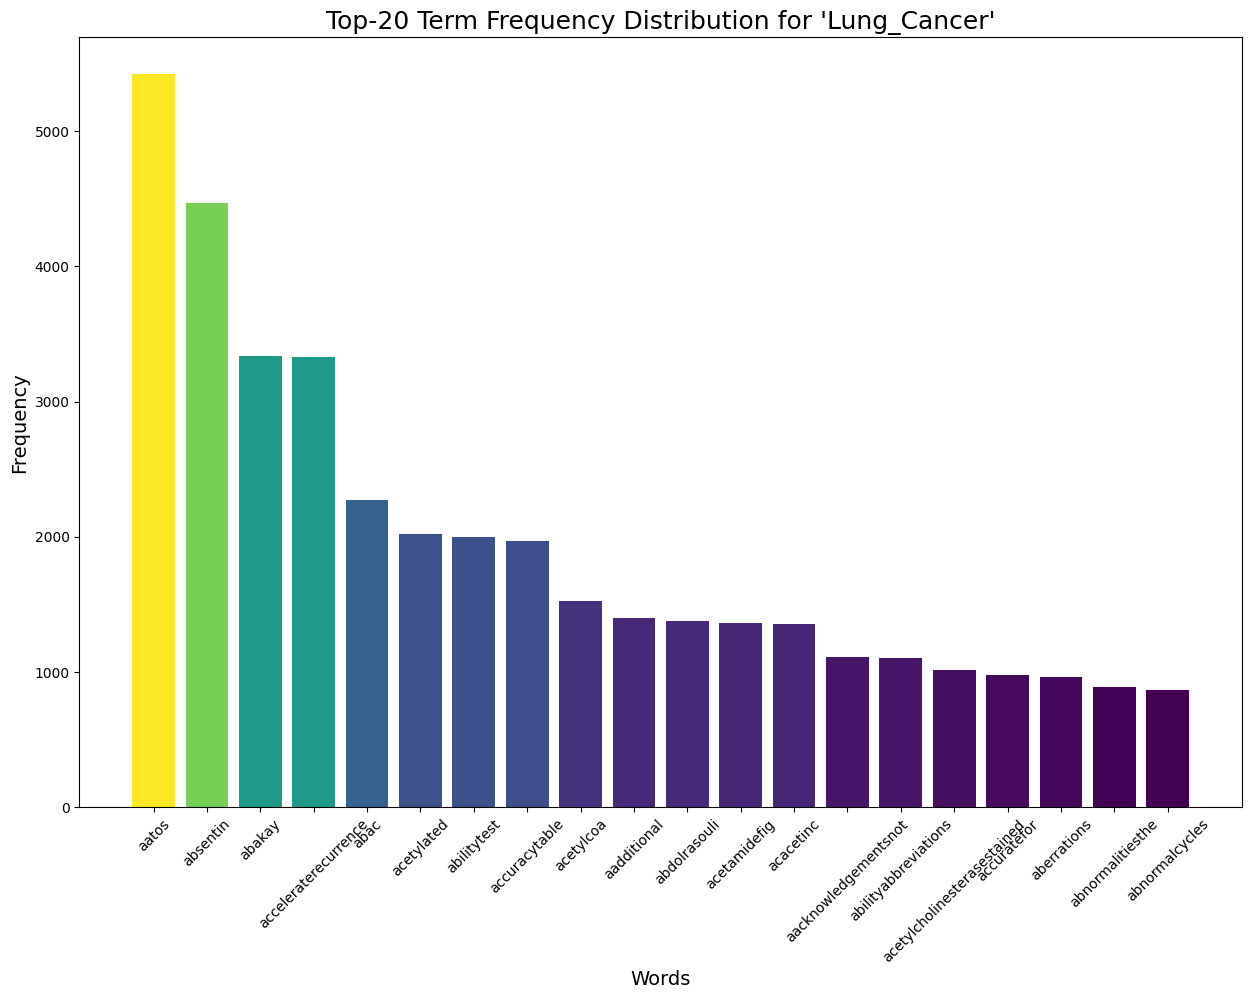

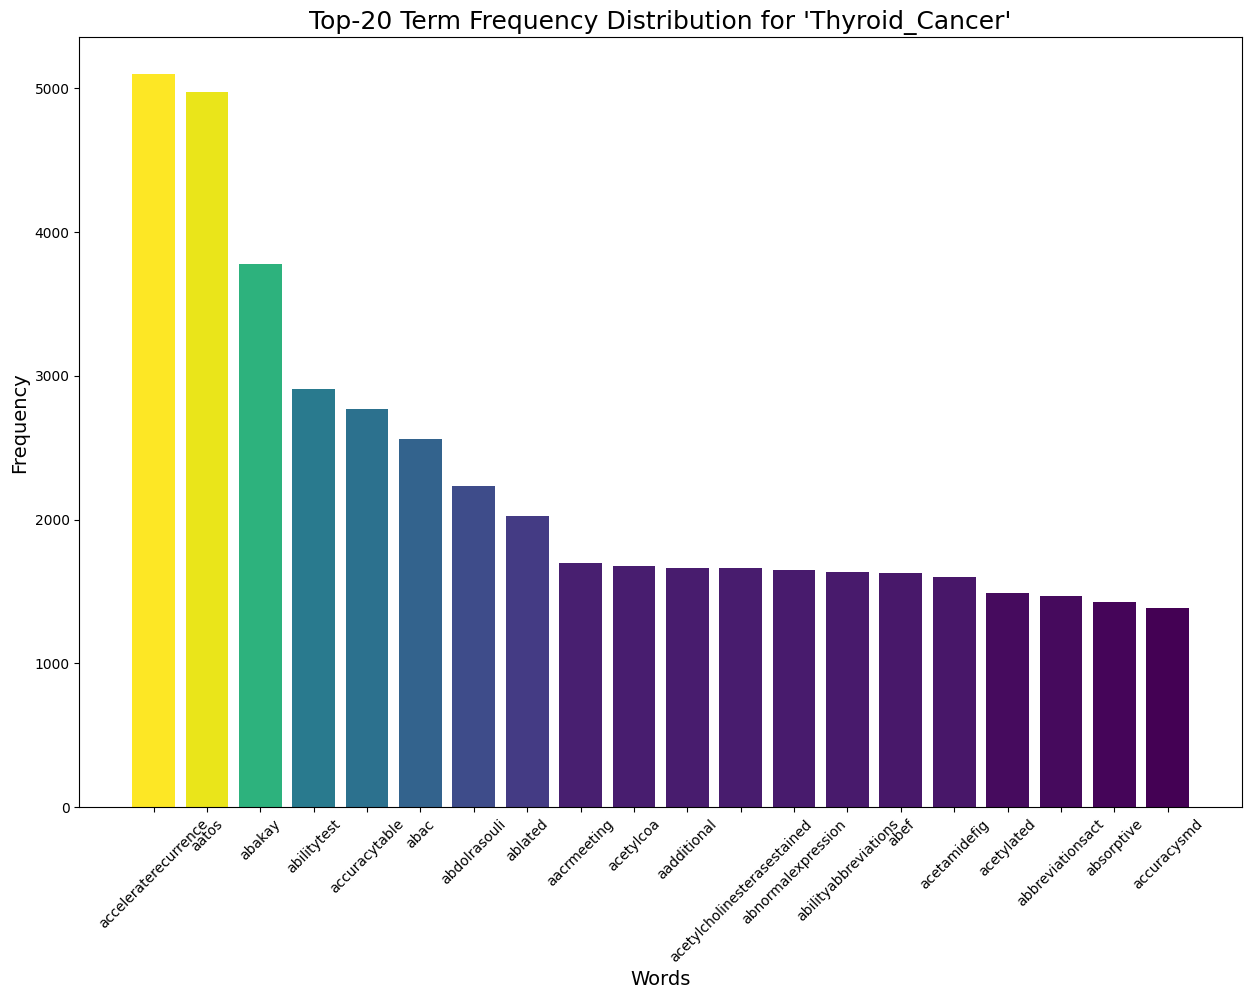

In [14]:
unique_classes, counts = np.unique(y_train, return_counts=True)
for unique_class in unique_classes:
    plot_term_frequency_distribution(X_train_vectorized_reduced,
                                     y_train,
                                     class_=unique_class,
                                     top=20)

### Class Distribution

Gets the top 20 words in the dataset, then plots each class' respective frequency of each word.

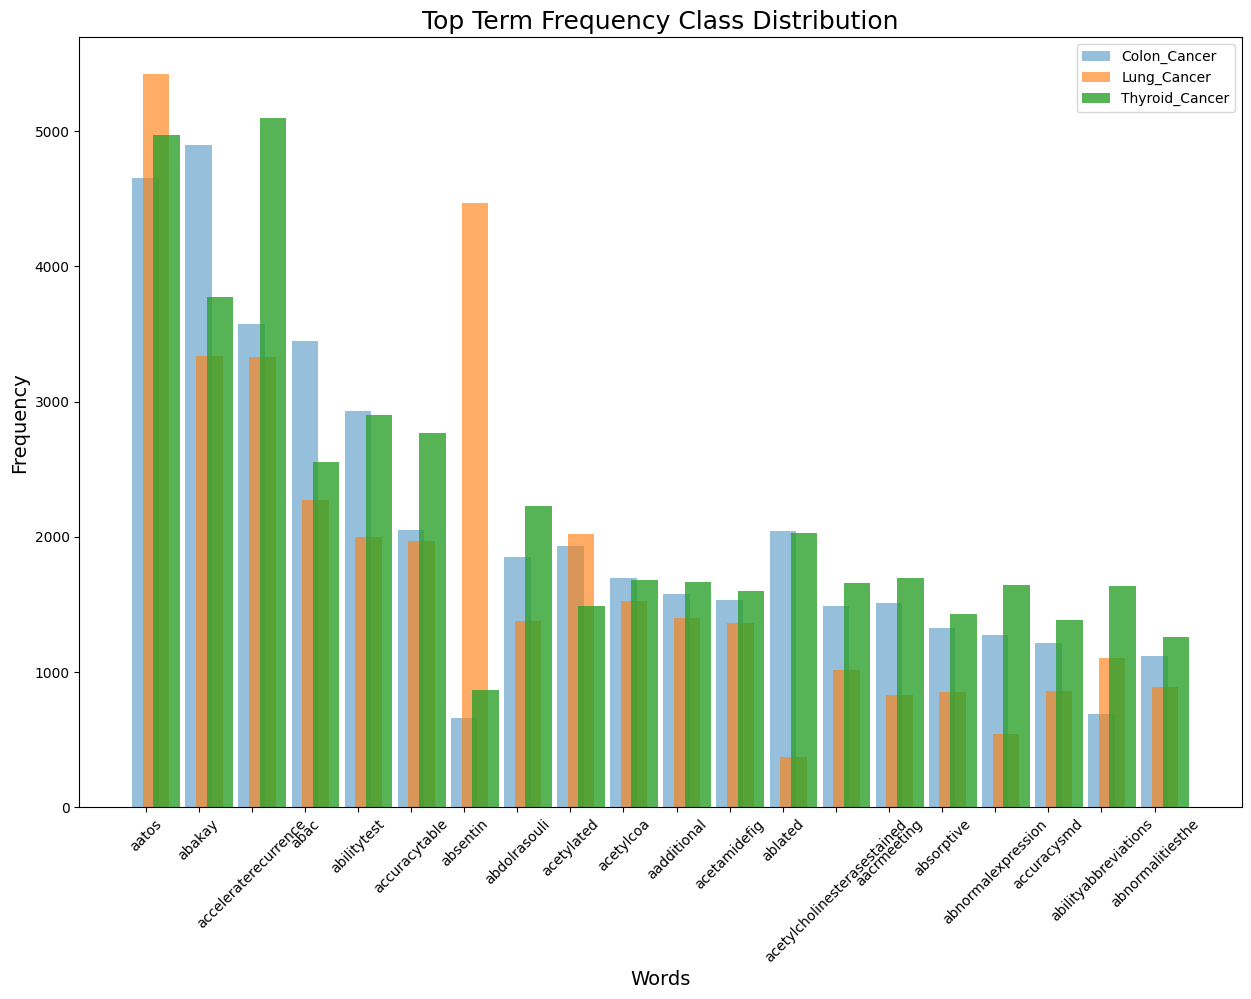

In [15]:
top_words_all_classes, _, top_indices_all_classes = get_top_info(X_train_vectorized_reduced, top=20)

plt.figure(figsize=(15, 10))
offset = 0.2
bar_width = 0.5

class_labels = np.unique(y_train)
lerp = lambda a, b, t: (1 - t) * a + t * b

for i, class_label in enumerate(class_labels, start=1):
    class_freqs = X_train_vectorized_reduced[y_train == class_label].sum(axis=0).A1[top_indices_all_classes]
    class_freqs = class_freqs[::-1]
    plt.bar(np.arange(len(top_words_all_classes)) + i * offset,
            class_freqs,
            align="center",
            label=class_label,
            alpha=(lerp(0.3, 0.8, i / len(class_labels))),
            width=bar_width)

plt.xticks(np.arange(len(top_words_all_classes)) + offset / 2 * (len(class_labels) - 1), top_words_all_classes, rotation=45)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top Term Frequency Class Distribution", fontsize=18)
plt.legend()
plt.show()

The number of instances of each class.

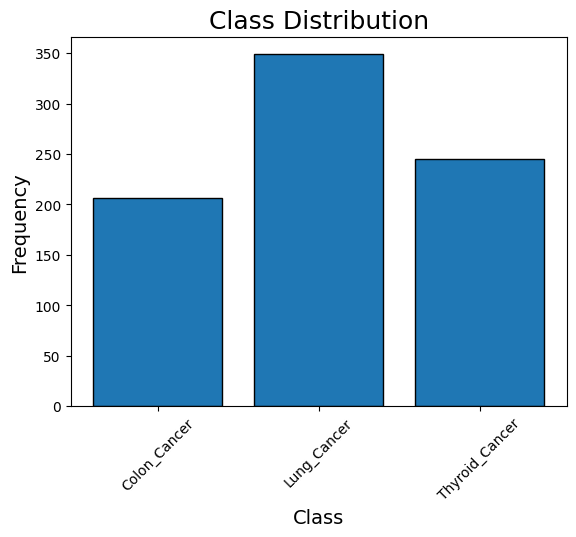

In [16]:
plt.bar(unique_classes,
        counts,
        edgecolor="black")
plt.xlabel("Class", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Class Distribution", fontsize=18)
plt.xticks(rotation=45)
plt.show()

# Preliminary Model Performance

We will run a rudementory GridSearch for a semi-optimal model and then feed that into a PCA and visualise the separating boundary to visualise how each model separates the boundaries.

## General Code & Functions

In [17]:
X_train_vectorized_reduced = X_train_vectorized_reduced.toarray()
X_test_vectorized_reduced = X_test_vectorized_reduced.toarray()

### Display Best

In [18]:
def display_best_results(data):
    """
    Prints the best parameters and best score from the given data.

    Parameters:
            data : Either a pandas DataFrame or a SearchCV object.
    """
    
    if isinstance(data, pd.DataFrame):
        best_score_index = data["mean_test_score"].idxmax()
        best_params = data.loc[best_score_index, "params"]
        best_score = data.loc[best_score_index, "mean_test_score"]
    else:
        best_params = data.best_params_
        best_score = data.best_score_

    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best Score: {best_score:.3f}")

### Dimensionality Reduction

Performs dimensionality reduction using PCA to reduce the feature space to 2 dimensions. It then generates a mesh grid that will be used with the estimator to predict values across the space and create a contour plot / decision boundary plot.

In [19]:
pca = PCA(n_components=2)
boundary_sharpness = 1000
X_train_2d = pca.fit_transform(X_train_vectorized_reduced)
x_coordinates, y_coordinates = X_train_2d[:, 0], X_train_2d[:, 1]

bounded_percentile = 1
x_bottom_percentile, x_top_percentile = np.percentile(x_coordinates, bounded_percentile), np.percentile(x_coordinates, 100 - bounded_percentile)
y_bottom_percentile, y_top_percentile = np.percentile(y_coordinates, bounded_percentile), np.percentile(y_coordinates, 100 - bounded_percentile)

# further scaling
further_scaling = 2
x_bottom_percentile, x_top_percentile = further_scaling * x_bottom_percentile, further_scaling * x_top_percentile
y_bottom_percentile, y_top_percentile = further_scaling * y_bottom_percentile, further_scaling * y_top_percentile

x_space = np.linspace(x_bottom_percentile, x_top_percentile, num=boundary_sharpness)
y_space = np.linspace(y_bottom_percentile, y_top_percentile, num=boundary_sharpness)

grid_x_values, grid_y_values = np.meshgrid(x_space, y_space)
grid_points = list(zip(grid_x_values.flatten(), grid_y_values.flatten()))

### Display Decision Boundary

In [20]:
def plot_decision_boundary(estimator, title):
    """
    Fits the estimator to the 2D training set and plots the decision boundary.

    Parameters:
        estimator : Classifier implementing a "fit" method.
        title : Desired title of plot.
    """
    
    estimator.fit(X_train_2d, y_train_encoded)
    plt.figure(figsize=(10, 7))
    grid_predictions = estimator.predict(grid_points).reshape(grid_x_values.shape)
    plt.contourf(grid_x_values, grid_y_values, grid_predictions, alpha=0.6, cmap="coolwarm")
    plt.scatter(x_coordinates, y_coordinates, c=y_train_encoded, cmap="coolwarm", s=5)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.xlim(x_bottom_percentile, x_top_percentile)  # x/y lim gotta match x/y space above
    plt.ylim(y_bottom_percentile, y_top_percentile)
    plt.title(title)
    plt.show()

## Naive Bayes Analysis

### Train NB Classifier

In [21]:
nb_param_grid = {
    "var_smoothing": np.logspace(-11, 11, 250)
}

nb_clf = GaussianNB()

nb_grid_search = GridSearchCV(nb_clf,
                              nb_param_grid,
                              scoring="accuracy",
                              n_jobs=4,
                              cv=5,
                              verbose=2,
                              return_train_score=True)

nb_grid_search.fit(X_train_vectorized_reduced, y_train_encoded);

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


### Hyperparameters: Alpha

In [22]:
display_best_results(nb_grid_search)

Best Parameters:
var_smoothing: 1.2484913627071786e-05
Best Score: 0.811


### Surface Plot

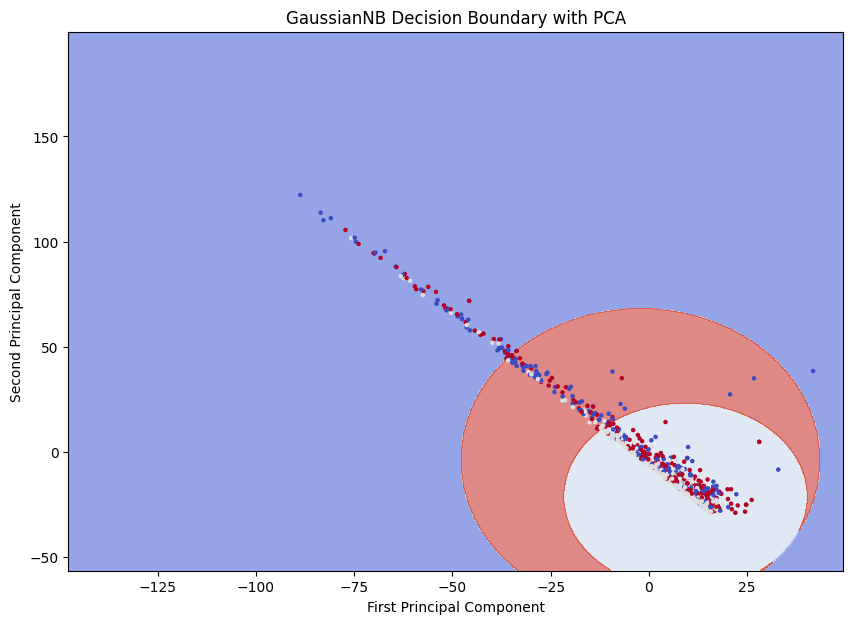

In [23]:
plot_decision_boundary(nb_grid_search.best_estimator_,
                       title="GaussianNB Decision Boundary with PCA")

## K-Nearest Neighbours Analysis

### Train kNN Classifier

In [24]:
knn_param_grid = {
    "n_neighbors": np.arange(1, 51, 1),
    "metric": ["euclidean", "cosine", "manhattan"]
}


knn_clf = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn_clf,
                               knn_param_grid,
                               scoring="accuracy",
                               n_jobs=4,
                               cv=5,
                               verbose=2,
                               return_train_score=True)

knn_grid_search.fit(X_train_vectorized_reduced, y_train_encoded);

Fitting 5 folds for each of 150 candidates, totalling 750 fits


### Hyperparameters: Neighbours and Distance Metric

In [25]:
display_best_results(knn_grid_search)

Best Parameters:
metric: cosine
n_neighbors: 1
Best Score: 0.674


### Surface Plot

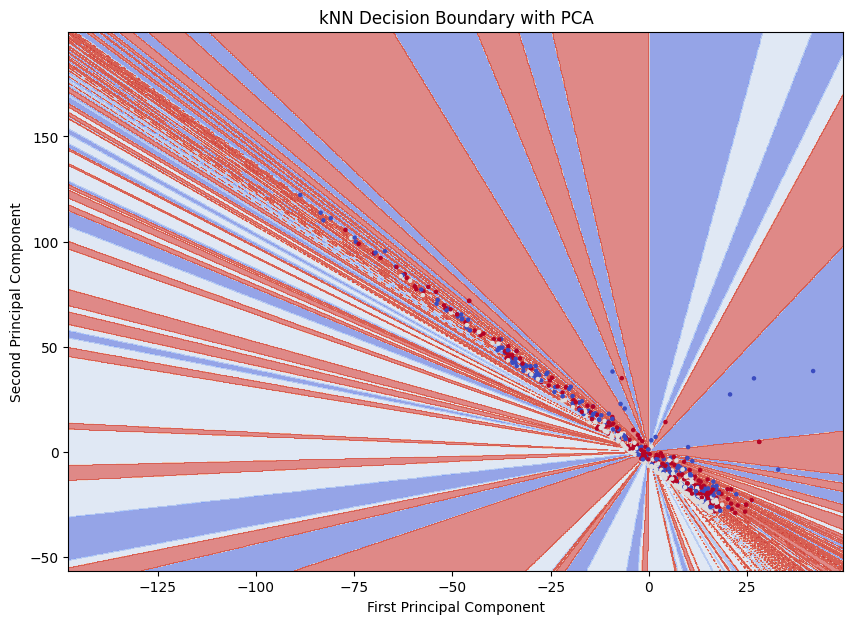

In [26]:
plot_decision_boundary(knn_grid_search.best_estimator_,
                       title="kNN Decision Boundary with PCA")

## Support Vector Machines Analysis

### Linear

#### Train SVM Classifier

In [27]:
svm_linear_param_grid = {
    "C": np.logspace(-11, 11, 23),
}

svm_linear_clf = SVC(kernel="linear")

svm_linear_grid_search = GridSearchCV(svm_linear_clf,
                                      svm_linear_param_grid,
                                      scoring="accuracy",
                                      n_jobs=4,
                                      cv=5,
                                      verbose=2,
                                      return_train_score=True)

svm_linear_grid_search.fit(X_train_vectorized_reduced, y_train_encoded);

Fitting 5 folds for each of 23 candidates, totalling 115 fits


#### Hyperparameters: C

In [28]:
display_best_results(svm_linear_grid_search)

Best Parameters:
C: 0.01
Best Score: 0.826


#### Surface Plot

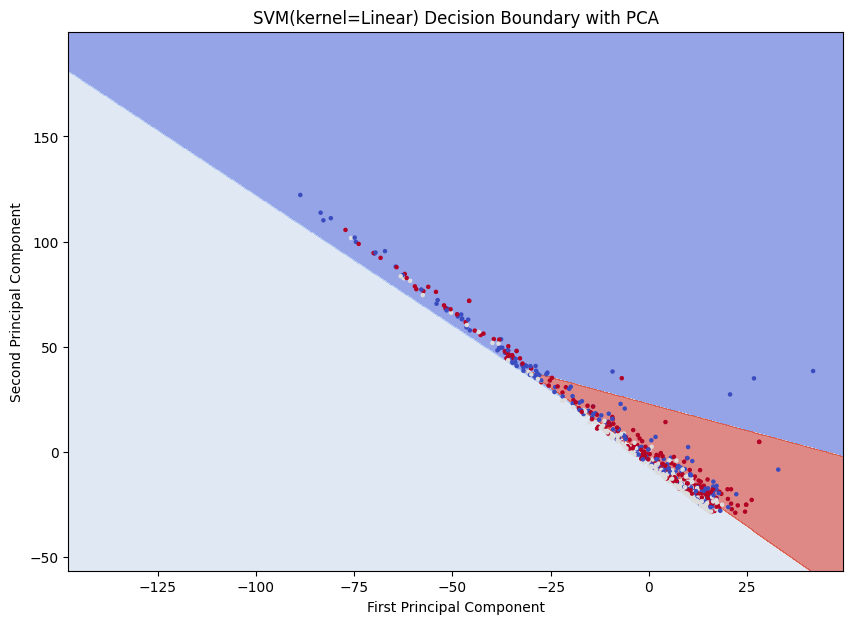

In [29]:
plot_decision_boundary(svm_linear_grid_search.best_estimator_,
                       title="SVM(kernel=Linear) Decision Boundary with PCA")

### RBF

#### Train SVM Classifier

In [30]:
svm_rbf_param_grid = {
    "gamma": np.logspace(-11, 11, 23),
}

svm_rbf_clf = SVC(kernel="rbf")

svm_rbf_grid_search = GridSearchCV(svm_rbf_clf,
                                   svm_rbf_param_grid,
                                   scoring="accuracy",
                                   n_jobs=4,
                                   cv=5,
                                   verbose=2,
                                   return_train_score=True)

svm_rbf_grid_search.fit(X_train_vectorized_reduced, y_train_encoded);

Fitting 5 folds for each of 23 candidates, totalling 115 fits


#### Hyperparameters: gamma

In [31]:
display_best_results(svm_rbf_grid_search)

Best Parameters:
gamma: 0.0001
Best Score: 0.754


#### Surface Plot

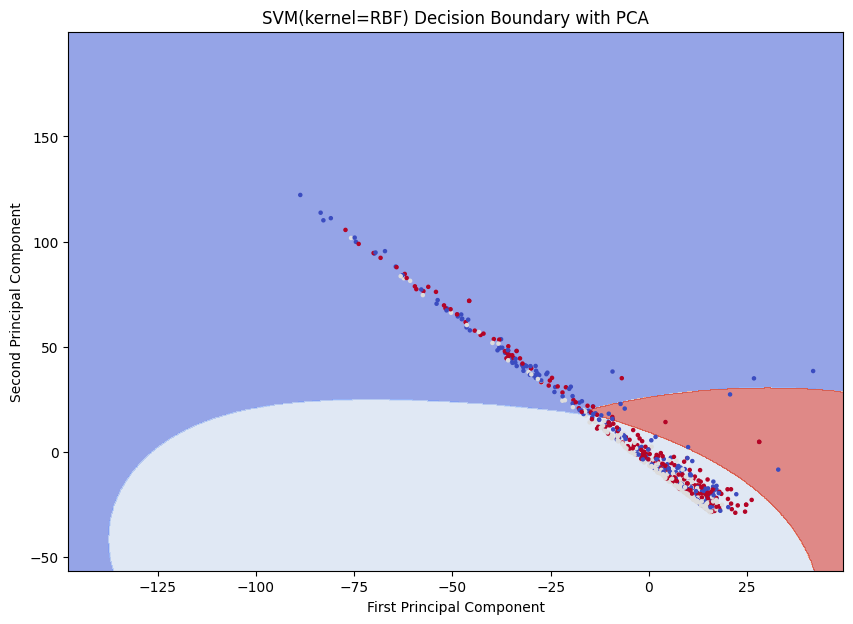

In [32]:
plot_decision_boundary(svm_rbf_grid_search.best_estimator_,
                       title="SVM(kernel=RBF) Decision Boundary with PCA")

## Neural Network Analysis

### Train NN Classifier

In [33]:
run = False

In [34]:
mlp_param_grid = {
        "hidden_layer_sizes": [1, 10, 20, 50, 100, 150, 200],
        "learning_rate_init": np.logspace(-11, 11, 23),
        "activation": ["identity", "relu", "logistic", "tanh"],
    }  # 1500 second runtime

if run:
    mlp_clf = MLPClassifier(random_state=42)

    mlp_grid_search = GridSearchCV(mlp_clf,
                                   mlp_param_grid,
                                   scoring="accuracy",
                                   n_jobs=4,
                                   cv=5,
                                   verbose=2,
                                   return_train_score=True)
    
    mlp_grid_search.fit(X_train_vectorized_reduced, y_train_encoded)
    with open("preliminary_MLPClassifier.pkl", "wb") as file:
        pickle.dump(mlp_grid_search, file)

In [35]:
with open("preliminary_MLPClassifier.pkl", "rb") as file:
    mlp_grid_search = pickle.load(file)

### Hyperparameters: Hidden Layers

In [36]:
display_best_results(mlp_grid_search)

Best Parameters:
activation: tanh
hidden_layer_sizes: 20
learning_rate_init: 0.01
Best Score: 0.807


### Surface Plot

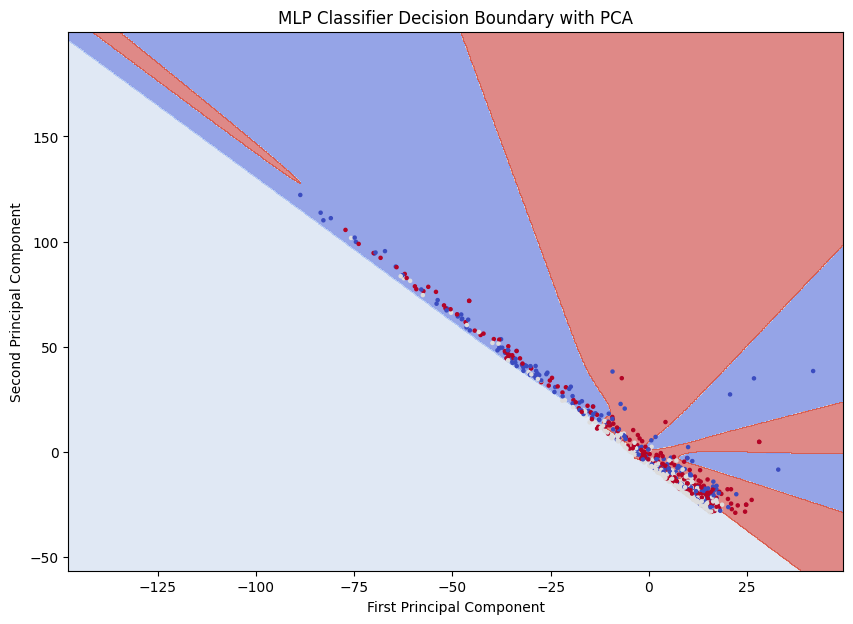

In [37]:
plot_decision_boundary(mlp_grid_search.best_estimator_,
                       title="MLP Classifier Decision Boundary with PCA")

### Effect of Layers on Loss

In [38]:
nn_clf = MLPClassifier(random_state=42)

hidden_layer_sizes = np.arange(5, 201, 5)
losses = []

for hidden_layer_size in hidden_layer_sizes:
    nn_clf.hidden_layer_sizes = hidden_layer_size  # set hyperparameter
    loss = cross_val_score(nn_clf,
                           X_train_vectorized_reduced,
                           y_train_encoded,
                           n_jobs=4,
                           cv=5,
                           verbose=0,
                           scoring="neg_log_loss")

    losses.append(-loss.mean())

#### Average Validation Cross-Entropy Loss

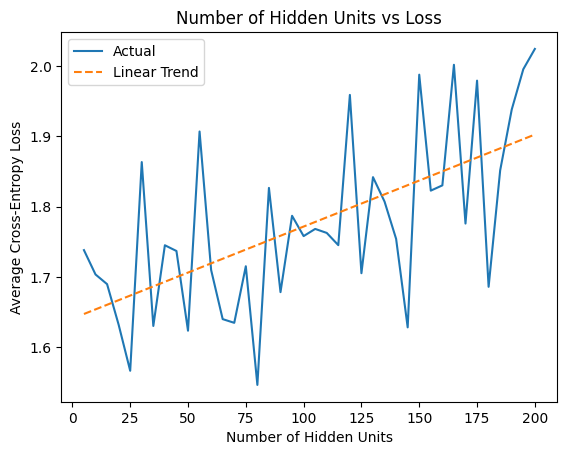

In [39]:
plt.plot(hidden_layer_sizes, 
         losses, 
         label="Actual")

# construct general trend
coefficients = np.polyfit(hidden_layer_sizes, losses, 1)
trend_line = np.poly1d(coefficients)
trend_line_x = np.linspace(hidden_layer_sizes[0], hidden_layer_sizes[-1], 100)
trend_line_y = trend_line(trend_line_x)
plt.plot(trend_line_x, 
         trend_line_y,
         linestyle="--",
         label="Linear Trend")

plt.xlabel("Number of Hidden Units")
plt.ylabel("Average Cross-Entropy Loss")
plt.title("Number of Hidden Units vs Loss")
plt.legend()
plt.show()

# Classification Quality Evaluation 

## General Code & Functions

### 2D Line Plot

In [40]:
def plot_2d_hyperparameters(train_results_df, test_score_df,
                            param_x=None, categorical_param=None,
                            title="", log_x=False):
    """
    Plots the 2d plot of accuracy Score for varying hyperparameters for the train score, val score and test score.

    Parameters:
        train_results_df : Training results.
        test_score_df : Testing results.
        param_x : The hyperparameter to plot on the x-axis.
        categorical_param : The hyperparameter to categorise the plot.
        title : Desired title of plot.
        log_x : If True, the x-axis values are log-transformed.
    """
    
    if categorical_param is not None:
        unique_values = np.unique(train_results_df[f"param_{categorical_param}"])
        for value in unique_values:
            train_ids_filtered = (train_results_df[f"param_{categorical_param}"] == value)
            test_ids_filtered = (test_score_df[f"param_{categorical_param}"] == value)
            train_subset = train_results_df[train_ids_filtered].sort_values(f"param_{param_x}")
            test_subset = test_score_df[test_ids_filtered].sort_values(f"param_{param_x}")
            plot_2d_hyperparameters(train_subset, test_subset, param_x, None, f"{title} ({categorical_param}={value})", log_x)
        return
    
    plt.figure(figsize=(15, 7))

    plot_info = [
        {"subset": train_results_df, "y_value": "mean_test_score", "label": "Validation"},
        {"subset": train_results_df, "y_value": "mean_train_score", "label": "Training"},
        {"subset": test_score_df, "y_value": "mean_test_score", "label": "Testing"}
    ]

    for i, plot in enumerate(plot_info):
        x_vals = plot["subset"][f"param_{param_x}"]
        if log_x:
            x_vals = x_vals.apply(lambda x: np.log10(x))

        plt.plot(x_vals,
                 plot["subset"][plot["y_value"]],
                 label=plot["label"])

    plt.title(title, fontsize=18)
    plt.xlabel(f"log({param_x})" if log_x else param_x, fontsize=14)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

### 3D Heatmap Plot

In [41]:
def plot_3d_hyperparameters(training_df, testing_df, param_x, param_y,
                            categorical_param, categories,
                            use_log_x=False, use_log_y=False,
                            reverse_x_axis=False, reverse_y_axis=False):
    """
    Plots the 3d heatmap of accuracy Score for varying hyperparameters for the train score, val score and test score.

    Parameters:
        training_df : Training results.
        testing_df : Testing results.
        param_x : The hyperparameter to plot on the x-axis.
        param_y : The hyperparameter to plot on the y-axis.
        categorical_param : The hyperparameter to categorise the plot.
        categories : List of categories for the categorical hyperparameter.
        use_log_x : If True, the x-axis values are log-transformed.
        use_log_y : If True, the y-axis values are log-transformed.
        reverse_x_axis : If True, the x-axis is reversed.
        reverse_y_axis : If True, the y-axis is reversed.
    """
    
    dfs = [training_df, training_df, testing_df]
    score_types = ["mean_test_score", "mean_train_score", "mean_test_score"]
    names = ["Training", "Validation", "Testing"]

    rows = len(categories)
    cols = len(dfs)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))

    v_min = min(df[score_type].min() for df, score_type in zip(dfs, score_types))
    v_max = max(df[score_type].max() for df, score_type in zip(dfs, score_types))
    for r, category in enumerate(categories):
        for c, (df, score_type, name) in enumerate(zip(dfs, score_types, names)):
            df_filtered = df[df[f"param_{categorical_param}"] == category]
            x_vals = df_filtered[f"param_{param_x}"]
            y_vals = df_filtered[f"param_{param_y}"]

            if use_log_x:
                x_vals = x_vals.apply(lambda x: np.log10(x))
            if use_log_y:
                y_vals = y_vals.apply(lambda x: np.log10(x))

            x_range = np.linspace(x_vals.min(), x_vals.max(), num=250)
            y_range = np.linspace(y_vals.min(), y_vals.max(), num=250)
            x_grid, y_grid = np.meshgrid(x_range, y_range)
            z = griddata((x_vals, y_vals), df_filtered[score_type], (x_grid, y_grid), method="cubic")

            ax = axs[r, c]
            cf = ax.contourf(x_grid, y_grid, z, levels=250, cmap="inferno", vmin=v_min, vmax=v_max)
            fig.colorbar(cf, ax=ax)
            ax.set_xlabel(f"log({param_x})" if use_log_x else param_x)
            ax.set_ylabel(f"log({param_y})" if use_log_y else param_y)
            if reverse_x_axis: ax.invert_xaxis()
            if reverse_y_axis: ax.invert_yaxis()
            ax.set_title(f"{name}({categorical_param}={category})")

    plt.tight_layout()
    plt.show()

## Effect of Training Dataset Size on Performance

### Define Classifiers

In [42]:
classifiers_information = {
    "GaussianNB": {
        "line_style": "-", "marker": "o", "colour": "b", "classifier": GaussianNB()
    },
    "KNeighborsClassifier": {
        "line_style": "--", "marker": "x", "colour": "r", "classifier": KNeighborsClassifier()
    },
    "SVC_linear": {
        "line_style": ":", "marker": "^", "colour": "g", "classifier": SVC(kernel='linear')
    },
    "SVC_rbf": {
        "line_style": "-.", "marker": "s", "colour": "m", "classifier": SVC(kernel='rbf')
    },
    "MLPClassifier": {
        "line_style": (0, (3, 5, 1, 5)), "marker": "D", "colour": "c", "classifier": MLPClassifier(random_state=42)
    }
}

### Train Classifiers

In [43]:
m_split_sizes = np.arange(0.1, 1.0, 0.1)
classifier_train_scores = []
classifier_test_scores = []

for clf_name in classifiers_information:
    clf_info = classifiers_information[clf_name]
    clf = clf_info["classifier"]
    sub_train_size_train_scores = []
    sub_train_size_test_scores = []

    for m in m_split_sizes:
        X_train_vectorized_m, _, y_train_encoded_m, _ = train_test_split(X_train_vectorized_reduced,
                                                                         y_train_encoded,
                                                                         train_size=m,
                                                                         random_state=42)
        #if clf_name == "GaussianNB":
        #    X_train_vectorized_m = X_train_vectorized_m.toarray()
        clf.fit(X_train_vectorized_m, y_train_encoded_m)
        y_pred_train_m = clf.predict(X_train_vectorized_m)
        y_pred_test_m = clf.predict(X_test_vectorized_reduced)# if clf_name != "GaussianNB" else X_test_vectorized_reduced.toarray())
        train_m_score = accuracy_score(y_train_encoded_m, y_pred_train_m)
        test_m_score = accuracy_score(y_test_encoded, y_pred_test_m)
        sub_train_size_train_scores.append(train_m_score)
        sub_train_size_test_scores.append(test_m_score)

    classifier_train_scores.append(sub_train_size_train_scores)
    classifier_test_scores.append(sub_train_size_test_scores)

### Training and Testing Accuracy Plots

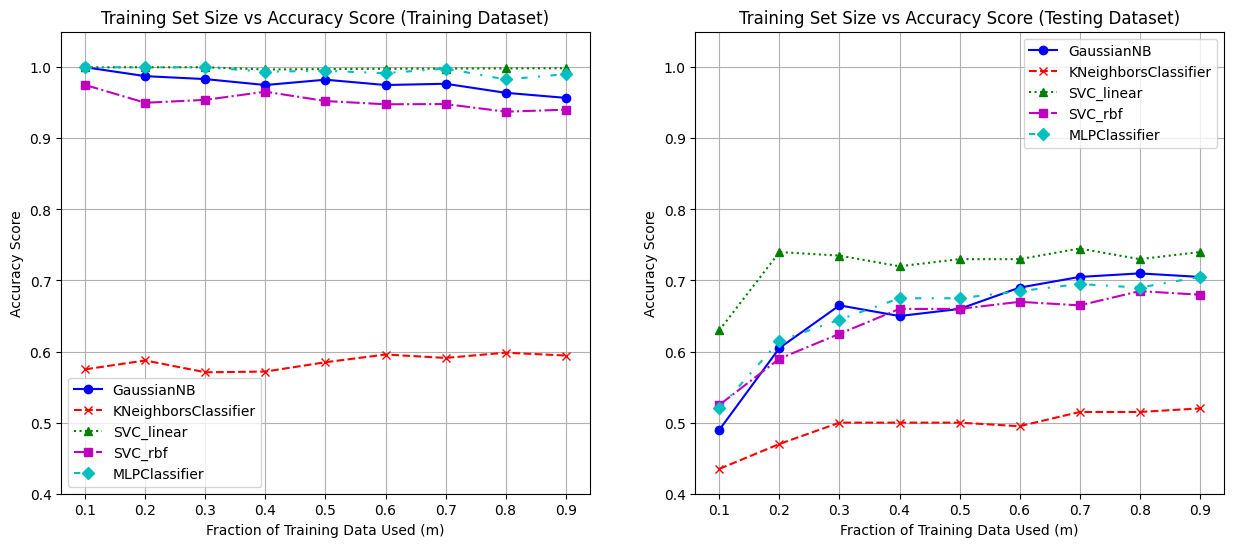

In [44]:
_, ax_ = plt.subplots(1, 2, figsize=(15, 6))
for ii, (dataset_name, dataset_type) in enumerate(zip(["Training", "Testing"],
                                                      [classifier_train_scores, classifier_test_scores])):
    for jj, clf_name in enumerate(classifiers_information):
        clf_info = classifiers_information[clf_name]
        ax_[ii].plot(m_split_sizes,
                     dataset_type[jj],
                     linestyle=clf_info["line_style"],
                     marker=clf_info["marker"],
                     color=clf_info["colour"],
                     label=clf_name)
    ax_[ii].set_xlabel("Fraction of Training Data Used (m)")
    ax_[ii].set_ylabel("Accuracy Score")
    ax_[ii].set_ylim(0.4, 1.05)
    ax_[ii].set_title(f"Training Set Size vs Accuracy Score ({dataset_name} Dataset)")
    ax_[ii].legend()
    ax_[ii].grid()

plt.show()

## Investigation of Hyperparameters

### Load Grid Search for Training & Validation

In [45]:
results_train_val = {}

In [46]:
results_train_val["GaussianNB"] = nb_grid_search
results_train_val["KNeighborsClassifier"] = knn_grid_search
results_train_val["SVC_linear"] = svm_linear_grid_search
results_train_val["SVC_rbf"] = svm_rbf_grid_search
results_train_val["MLPClassifier"] = mlp_grid_search

### Initiate Testing Scores

This section of code sees how the performance on the unseen test set varies as the hyperparameters change. This is so the performance can be compared to the previous search which attained the training and validation scores.

In [47]:
classifier_param_spaces = [
    {"name": "GaussianNB", "classifier": nb_grid_search.best_estimator_, "parameters": nb_param_grid},
    {"name": "KNeighborsClassifier", "classifier": knn_grid_search.best_estimator_, "parameters": knn_param_grid},
    {"name": "SVC_linear", "classifier": svm_linear_grid_search.best_estimator_, "parameters": svm_linear_param_grid},
    {"name": "SVC_rbf", "classifier": svm_rbf_grid_search.best_estimator_, "parameters": svm_rbf_param_grid},
    {"name": "MLPClassifier", "classifier": mlp_grid_search.best_estimator_, "parameters": mlp_param_grid},
]

In [48]:
def fit_model(combination, parameter_names):
    """
    Fits a model with given hyperparameters and calculates the accuracy score.

    Parameters:
        combination : The set of values for the hyperparameters.
        parameter_names : The set of corresponding names for the hyperparameters

    Returns:
        test_score : A dictionary that stores the hyperparameters, their values, and the mean accuracy score.
    """
    
    #if "var_smoothing" in parameter_names:
    #    params = dict(zip(parameter_names, combination))
    #    classifier_model.set_params(**params)
    #    classifier_model.fit(X_train_vectorized_reduced.toarray(), y_train_encoded)
    #    y_predicted = classifier_model.predict(X_test_vectorized_reduced.toarray())
    #    accuracy = accuracy_score(y_test_encoded, y_predicted)
    #else:
    params = dict(zip(parameter_names, combination))
    classifier_model.set_params(**params)
    classifier_model.fit(X_train_vectorized_reduced, y_train_encoded)
    y_predicted = classifier_model.predict(X_test_vectorized_reduced)
    accuracy = accuracy_score(y_test_encoded, y_predicted)
        
    test_score = defaultdict(list)
    for parameter, value in params.items():
        test_score[f"param_{parameter}"].append(value)
    test_score["params"].append(params)
    test_score["mean_test_score"].append(accuracy)
    return test_score

In [49]:
running = [False] * 5
for run, classifier_info in zip(running, classifier_param_spaces):
    if run is False:
        continue

    classifier_name = classifier_info["name"]
    classifier_model = classifier_info["classifier"]
    param_grid = classifier_info["parameters"]
    
    verbose = 9
    n_jobs = 4

    param_keys, param_values = zip(*param_grid.items())
    param_combinations = list(product(*param_values))
    total_tests = len(param_combinations)
        
    print(f"Fitting {total_tests} models for {classifier_name}")

    test_scores_ = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(fit_model)(combination, param_keys) for combination in param_combinations
    )

    combined_test_scores = defaultdict(list)
    for test_score_ in test_scores_:
        for k, v in test_score_.items():
            combined_test_scores[k].extend(v)

    combined_test_scores = pd.DataFrame(combined_test_scores)
    with open(f"test_score_dataframes_{classifier_name}.pkl", "wb") as file:
        pickle.dump(combined_test_scores, file)

### Load Testing Scores

In [50]:
results_test = {}
for classifier_name in classifiers_information:
    with open(f"test_score_dataframes_{classifier_name}.pkl", "rb") as file:
        results_test[classifier_name] = pickle.load(file)

### Training & Testing Performance for Best Tuned Models

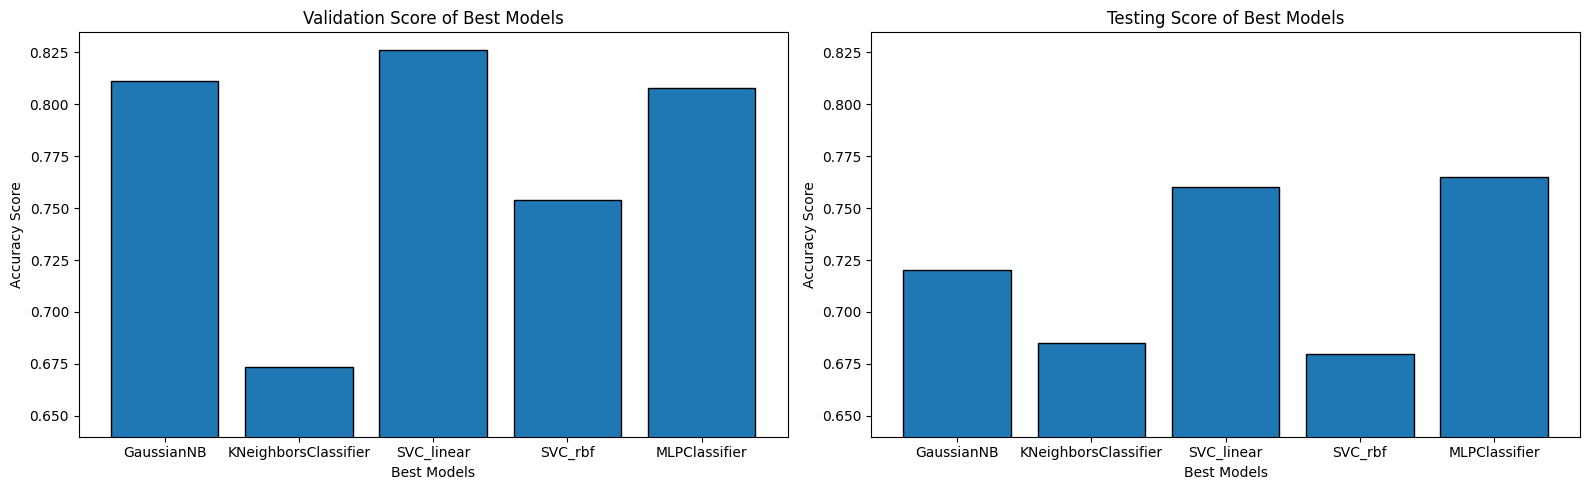

In [51]:
plot_scores = {
    "Validation Score of Best Models": [res.best_score_ for res in results_train_val.values()],
    "Testing Score of Best Models": [res["mean_test_score"].max() for res in results_test.values()],
}

all_scores = [score for scores in plot_scores.values() for score in scores]
_, axes_ = plt.subplots(1, 2, figsize=(16, 5))
for ax_, (best_model_title, scores) in zip(axes_, plot_scores.items()):
    ax_.bar(classifiers_information.keys(),
            scores,
            edgecolor="black")
    ax_.set_ylim(min(all_scores) * 0.95, max(all_scores) * 1.01) 
    ax_.set_xlabel("Best Models")
    ax_.set_ylabel("Accuracy Score")
    ax_.set_title(best_model_title)

plt.tight_layout()
plt.show()

### Naive Bayes

In [52]:
nb_grid_search_train_val = results_train_val["GaussianNB"]
nb_test_score_df = results_test["GaussianNB"]

#### Best Training Parameters & Score

In [53]:
display_best_results(nb_grid_search_train_val)

Best Parameters:
var_smoothing: 1.2484913627071786e-05
Best Score: 0.811


#### Best Testing Parameters & Score

In [54]:
display_best_results(nb_test_score_df)

Best Parameters:
var_smoothing: 1.5021276049021075e-11
Best Score: 0.720


#### Hyperparameter Space Performance

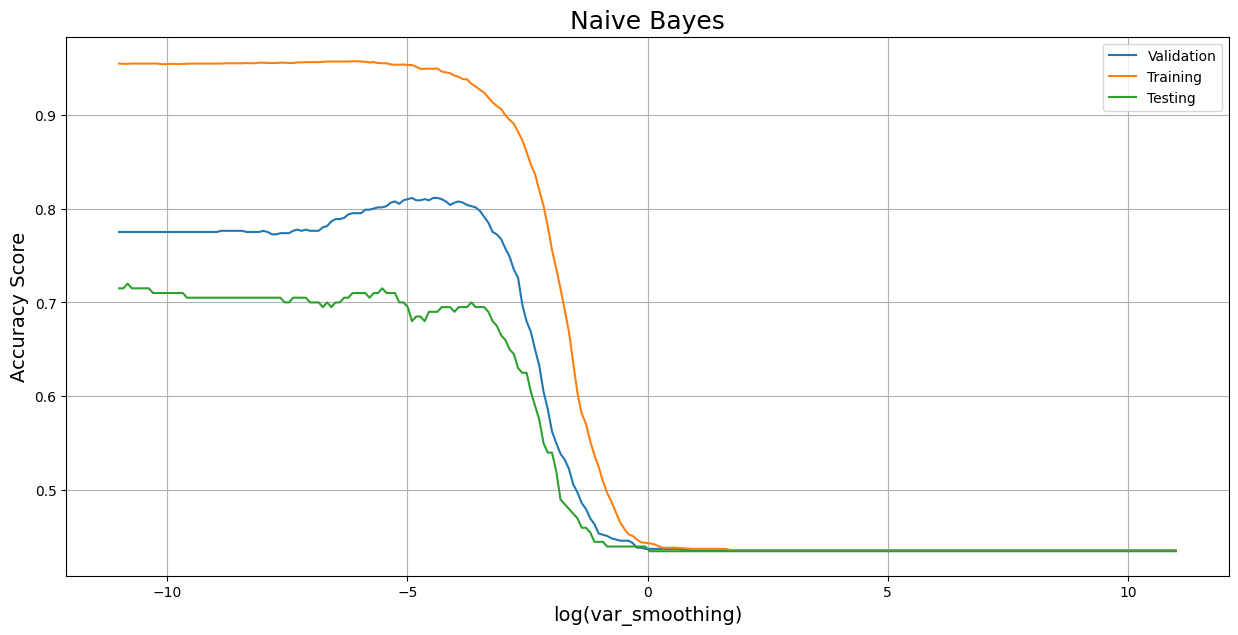

In [55]:
nb_train_val_cv_results_ = pd.DataFrame(nb_grid_search_train_val.cv_results_)
plot_2d_hyperparameters(nb_train_val_cv_results_, nb_test_score_df,
                        param_x="var_smoothing", categorical_param=None,
                        title="Naive Bayes",
                        log_x=True)

### K-Nearest Neighbours

In [56]:
knn_grid_search_train_val = results_train_val["KNeighborsClassifier"]
knn_test_score_df = results_test["KNeighborsClassifier"]

#### Best Training Parameters & Score

In [57]:
display_best_results(knn_grid_search_train_val)

Best Parameters:
metric: cosine
n_neighbors: 1
Best Score: 0.674


#### Best Testing Parameters & Score

In [58]:
display_best_results(knn_test_score_df)

Best Parameters:
n_neighbors: 4
metric: cosine
Best Score: 0.685


#### Hyperparameter Space Performance

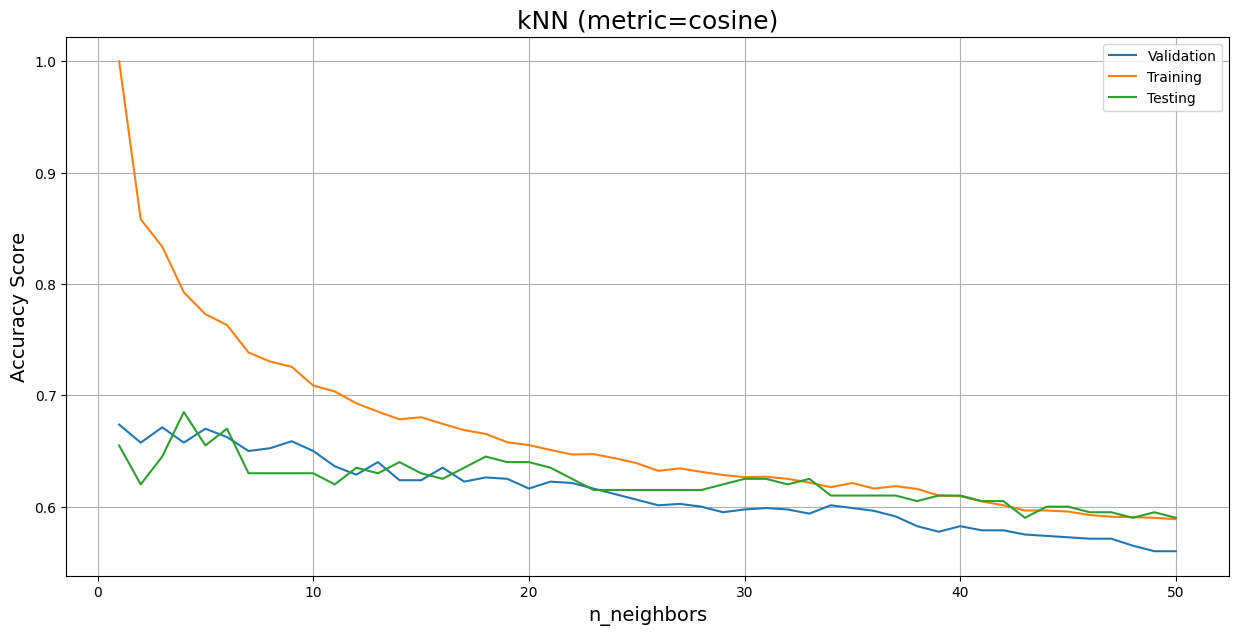

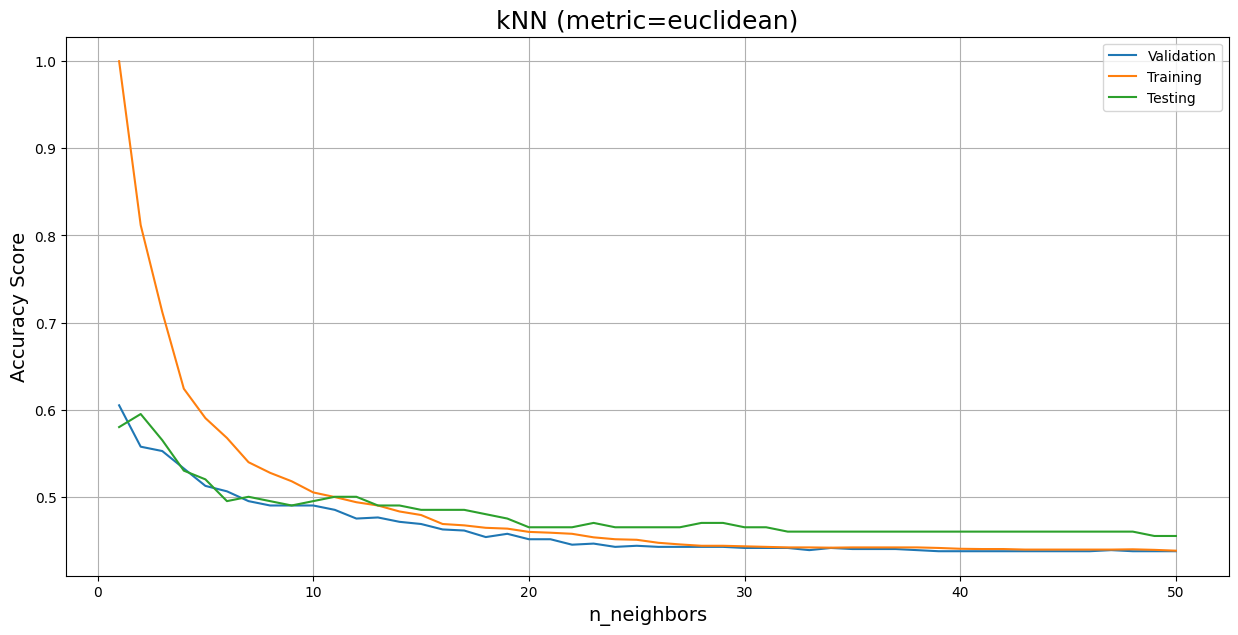

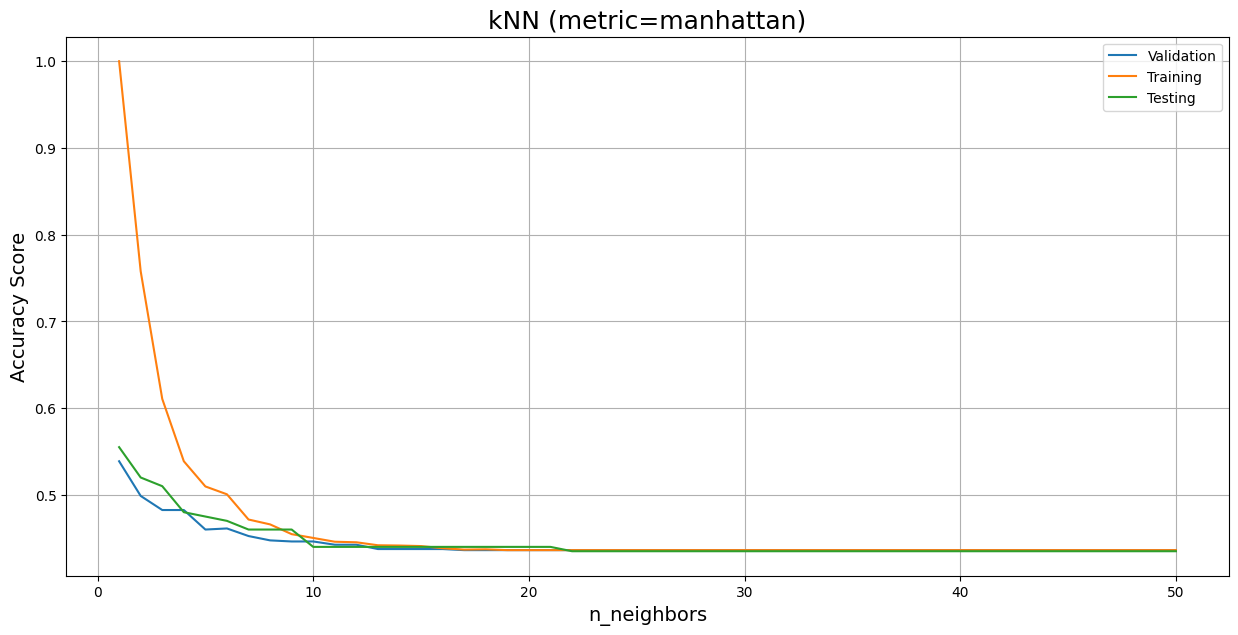

In [59]:
knn_train_val_cv_results_ = pd.DataFrame(knn_grid_search_train_val.cv_results_)
plot_2d_hyperparameters(knn_train_val_cv_results_, knn_test_score_df,
                        param_x="n_neighbors", categorical_param="metric",
                        title="kNN")

### Support Vector Machine

#### Linear

In [60]:
svm_linear_grid_search_train_val = results_train_val["SVC_linear"]
svm_linear_test_score_df = results_test["SVC_linear"]

##### Best Training Parameters & Score

In [61]:
display_best_results(svm_linear_grid_search_train_val)

Best Parameters:
C: 0.01
Best Score: 0.826


##### Best Testing Parameters & Score

In [62]:
display_best_results(svm_linear_test_score_df)

Best Parameters:
C: 0.1
Best Score: 0.760


##### Hyperparameter Space Performance

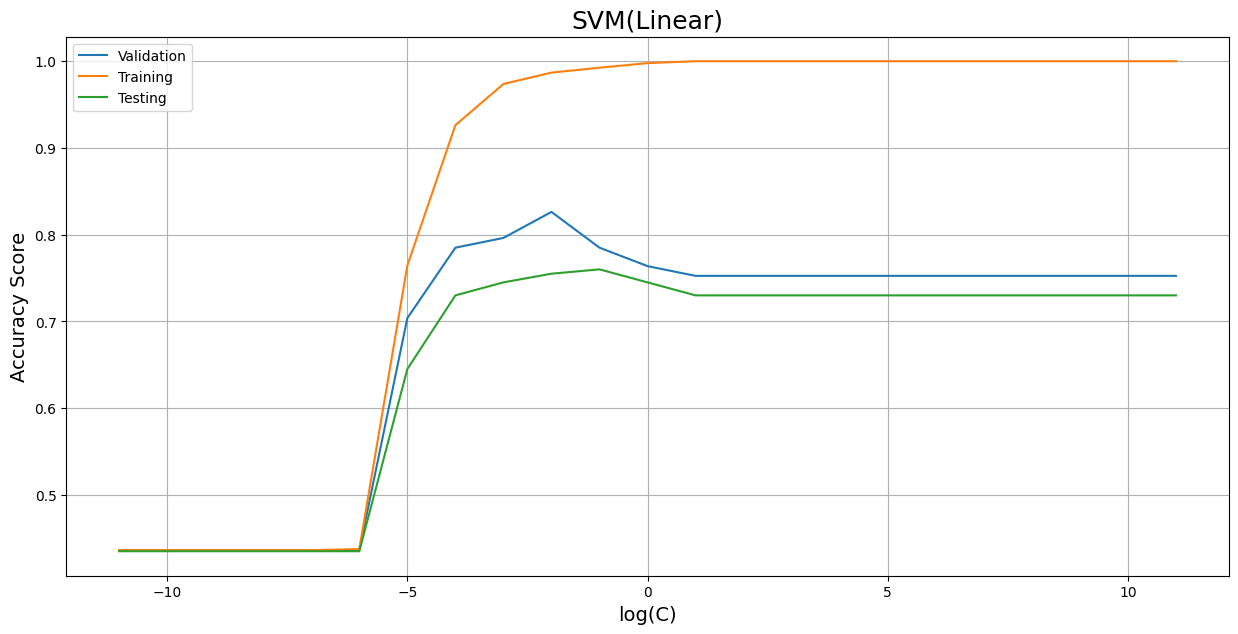

In [63]:
svm_linear_train_val_cv_results_ = pd.DataFrame(svm_linear_grid_search_train_val.cv_results_)
plot_2d_hyperparameters(svm_linear_train_val_cv_results_, svm_linear_test_score_df,
                        param_x="C", categorical_param=None,
                        title="SVM(Linear)",
                        log_x=True)

#### RBF

In [64]:
svm_rbf_grid_search_train_val = results_train_val["SVC_rbf"]
svm_rbf_test_score_df = results_test["SVC_rbf"]

##### Best Training Parameters & Score

In [65]:
display_best_results(svm_rbf_grid_search_train_val)

Best Parameters:
gamma: 0.0001
Best Score: 0.754


##### Best Testing Parameters & Score

In [66]:
display_best_results(svm_rbf_test_score_df)

Best Parameters:
gamma: 0.0001
Best Score: 0.680


##### Hyperparameter Space Performance

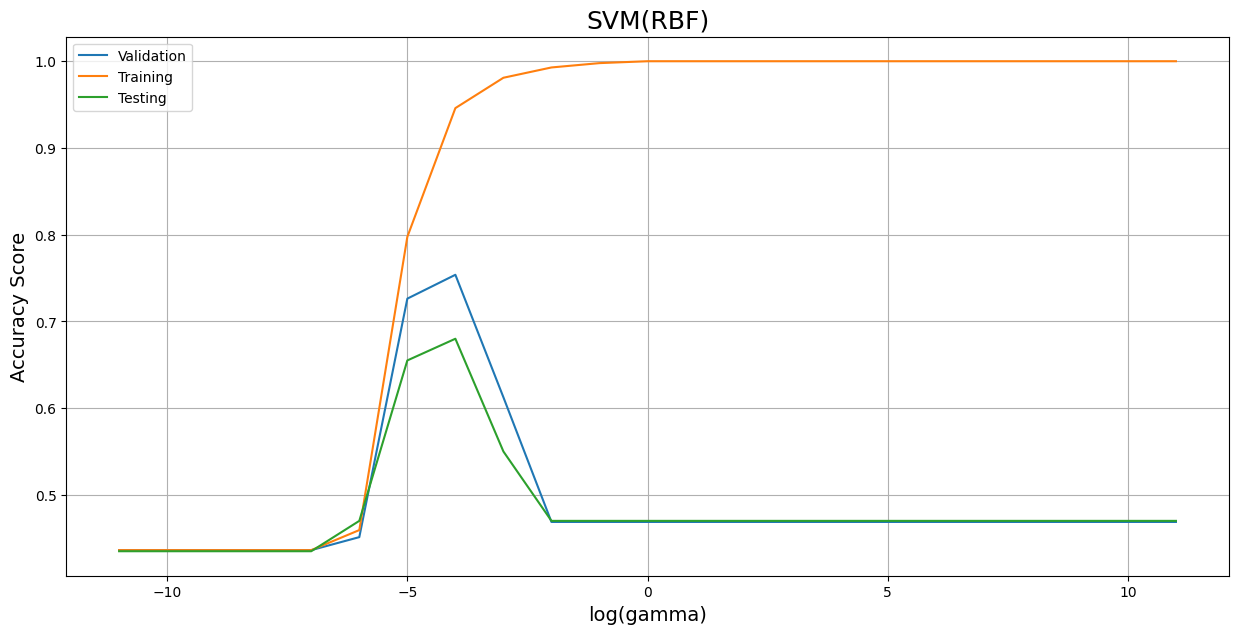

In [67]:
svm_rbf_train_val_cv_results_ = pd.DataFrame(svm_rbf_grid_search_train_val.cv_results_)
plot_2d_hyperparameters(svm_rbf_train_val_cv_results_, svm_rbf_test_score_df,
                        param_x="gamma", categorical_param=None,
                        title="SVM(RBF)",
                        log_x=True)

### Neural Net

In [68]:
nn_grid_search_train_val = results_train_val["MLPClassifier"]
nn_test_score_df = results_test["MLPClassifier"]

#### Best Training Parameters & Score

In [69]:
display_best_results(nn_grid_search_train_val)

Best Parameters:
activation: tanh
hidden_layer_sizes: 20
learning_rate_init: 0.01
Best Score: 0.807


#### Best Testing Parameters & Score

In [70]:
display_best_results(nn_test_score_df)

Best Parameters:
hidden_layer_sizes: 50
learning_rate_init: 10.0
activation: identity
Best Score: 0.765


#### Hyperparameter Space Performance

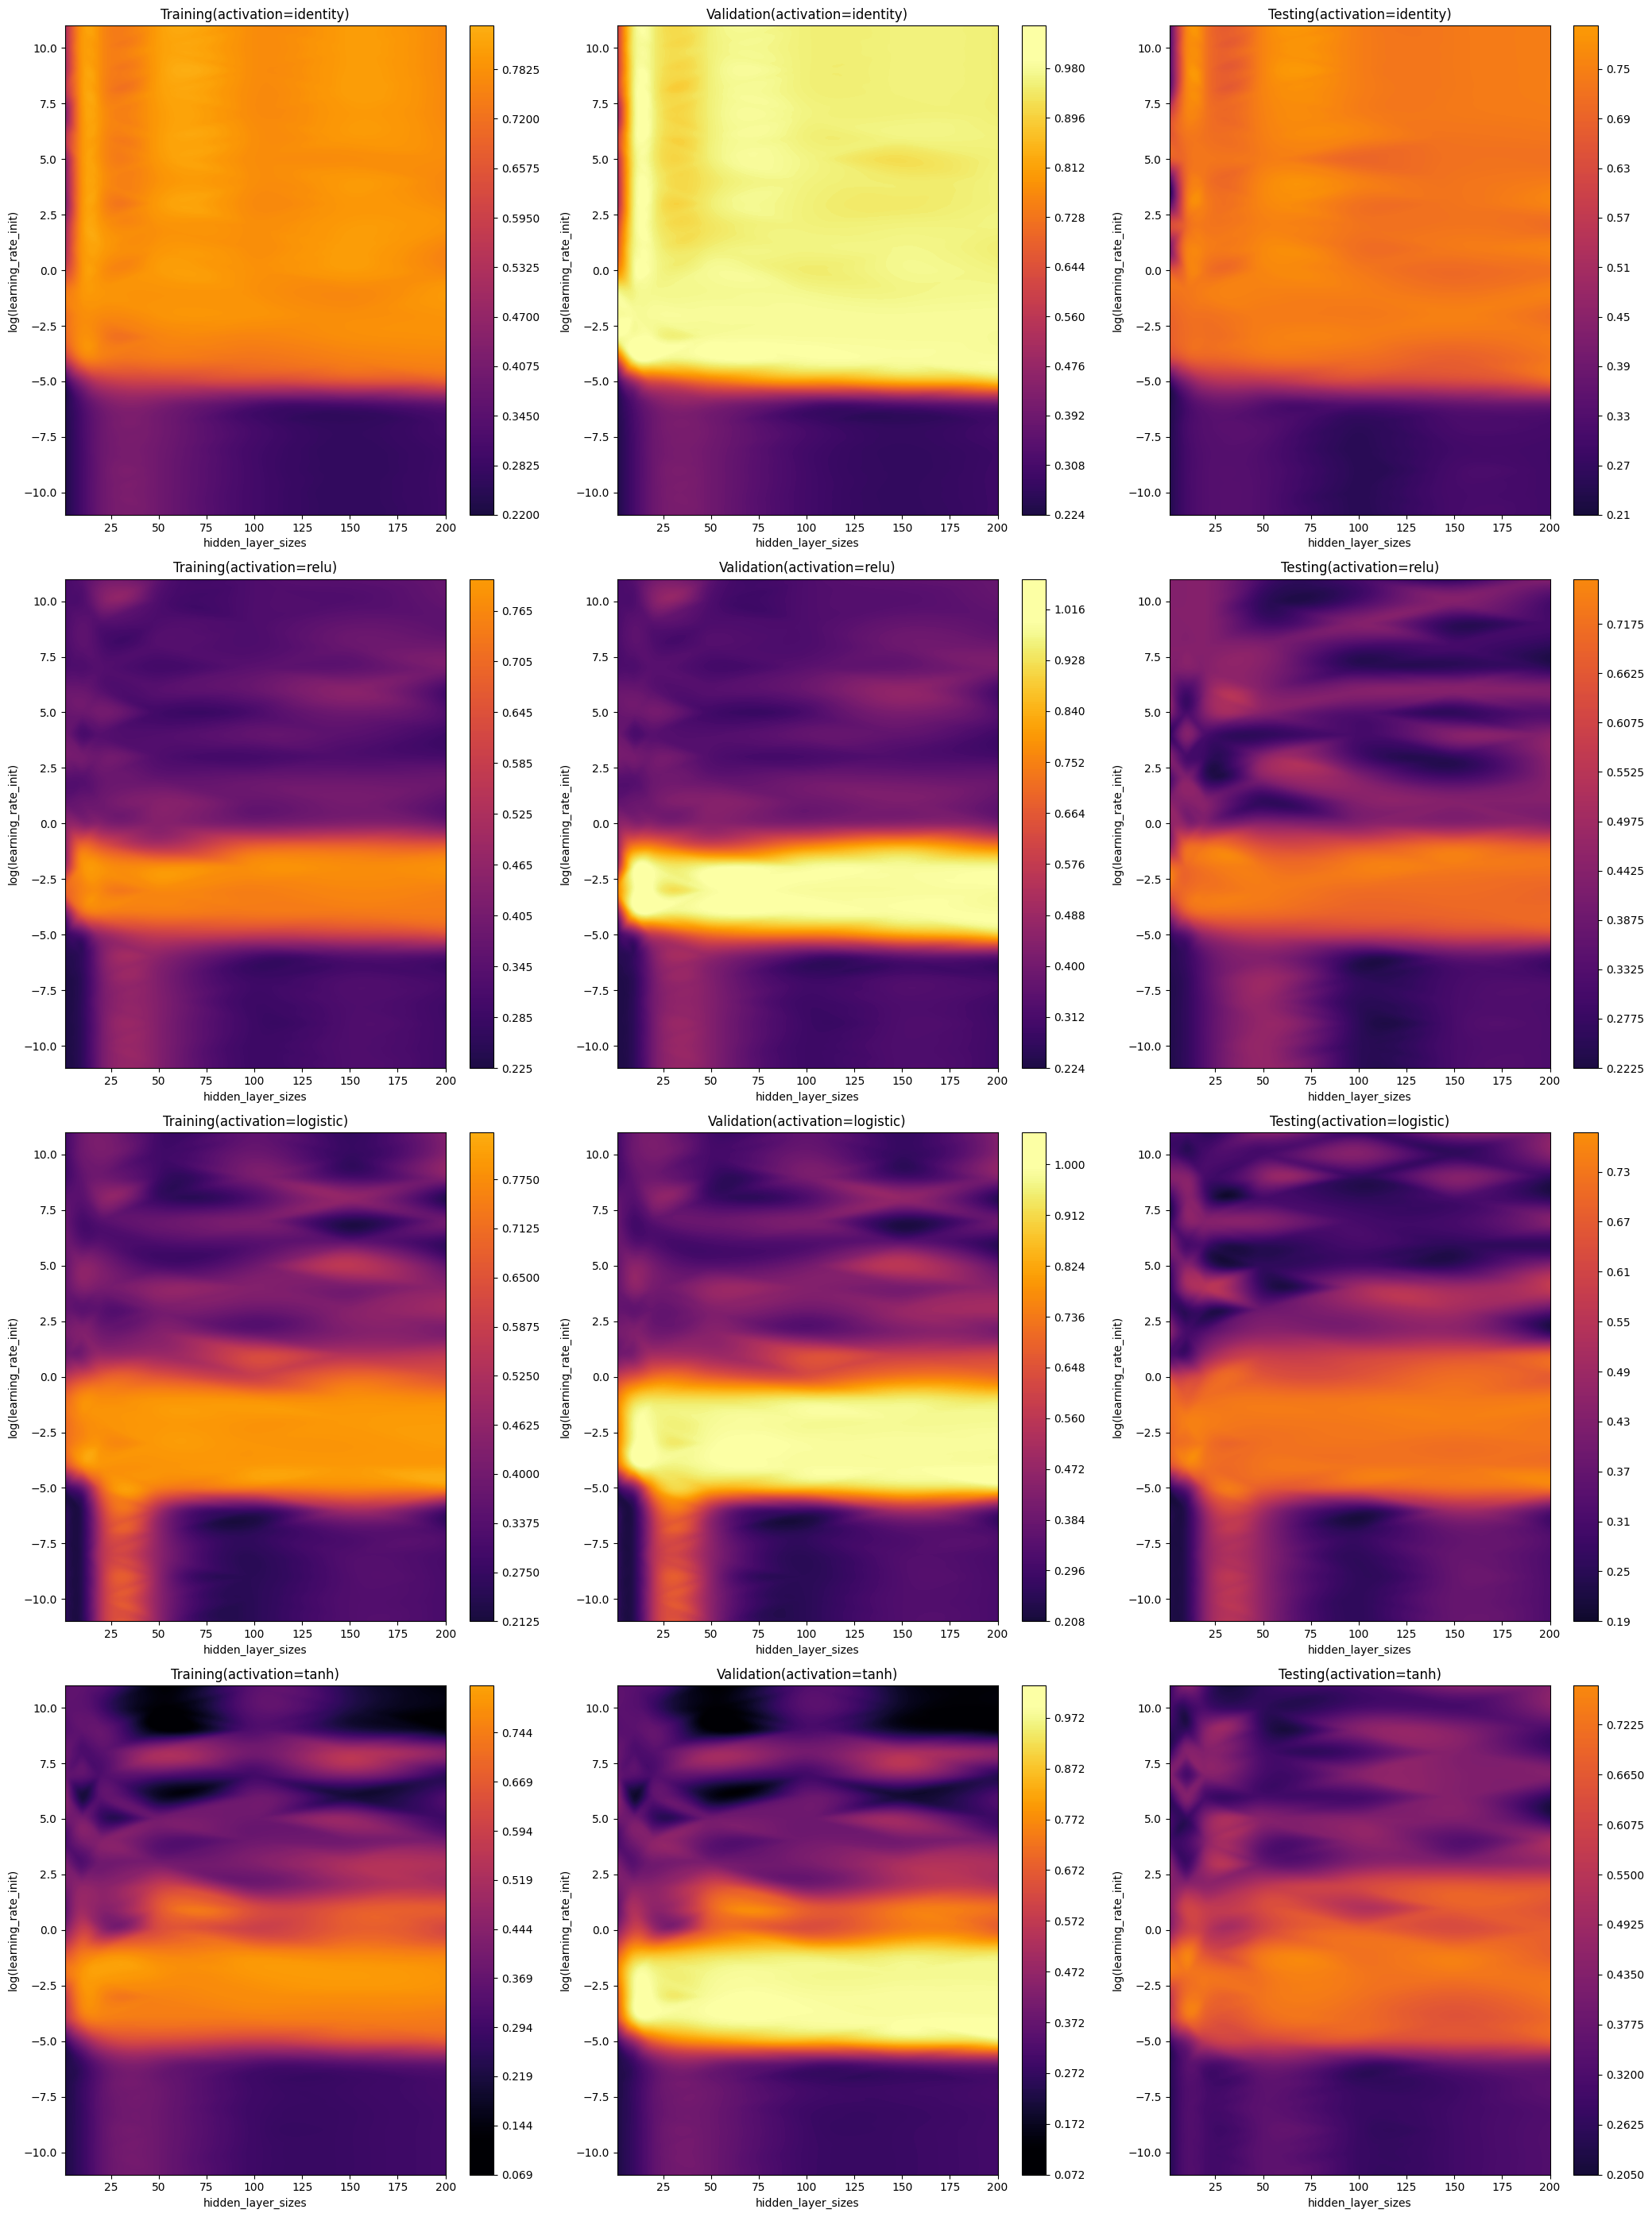

In [71]:
nn_train_val_cv_results_ = pd.DataFrame(nn_grid_search_train_val.cv_results_)
plot_3d_hyperparameters(nn_train_val_cv_results_, nn_test_score_df,
                        param_x="hidden_layer_sizes", param_y="learning_rate_init",
                        categorical_param="activation",
                        categories=["identity", "relu", "logistic", "tanh"],
                        use_log_x=False, use_log_y=True,
                        reverse_x_axis=False, reverse_y_axis=False)